# TP2: Regresión del valor de valor medio de casas en distritos de California - Solución

![Districtos de California](resources/ca_map_counties.png "Districtos de California")

## Introducción - California Housing

Este es un popular [dataset](https://scikit-learn.org/stable/datasets/real_world.html#california-housing-dataset) que vamos a estar leyendo desde **Scikit-Learn**.

Se requiere construir una regresión que nos permita predecir el valor de valor medio de casas en distritos de California (medidos en ciento de miles de dólares $100.000). Este dataset deriva del censo de 1990 de EEUU, donde cada observación es un bloque. Un bloque es la unidad geográfica más pequeña para la cual la Oficina del Censo de EE. UU. publica datos de muestra (un bloque típicamente tiene una población de 600 a 3,000 personas).

Un hogar es un grupo de personas que residen dentro de una casa. Dado que el número promedio de habitaciones y dormitorios en este conjunto de datos se proporciona por hogar, estas columnas pueden tomar valores grandes para grupos de bloques con pocos hogares y muchas casas vacías.

Los atributos en el orden que se guardaron en el dataset son:

- `MedInc`: Ingreso medio en el bloque
- `HouseAge`: Edad mediana de las casas en el bloque
- `AveRooms`: Número promedio de habitaciones por hogar.
- `AveBedrms`: Número promedio de dormitorios por hogar.
- `Population`: Población del bloque
- `AveOccup`: Número promedio de miembros por hogar.
- `Latitude`: Latitud del bloque
- `Longitude`: Longitud del bloque

## Tareas y preguntas a resolver:

In [90]:
# Importación de librerías.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

from sklearn.linear_model import LinearRegression, Ridge

sns.set_theme(context='notebook', style='dark')

In [91]:
# Leemos el dataset
X, y = fetch_california_housing(as_frame=True, return_X_y=True)

# Juntamos los datos.
df_housing = pd.concat([X, y], axis=1)

print(f'Datos obtenidos: ')
df_housing.sample(n=5)

Datos obtenidos: 


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
17319,5.5106,10.0,5.789976,1.016706,966.0,2.305489,34.60,-120.12,2.90900
6230,3.6648,34.0,4.297539,0.944072,1230.0,2.751678,34.06,-117.94,1.93900
5259,13.9470,29.0,8.494816,1.052780,2919.0,2.751178,34.11,-118.51,5.00001
11023,4.0484,15.0,5.389916,1.087395,1414.0,2.376471,33.80,-117.82,1.65600
4078,4.3000,41.0,5.445469,1.072197,1221.0,1.875576,34.15,-118.36,5.00001


In [92]:
# Chequeamos la estadistica principal.
df_housing.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


In [93]:
# Chequeamos los tipos de datos.
df_housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       20640 non-null  float64
 1   HouseAge     20640 non-null  float64
 2   AveRooms     20640 non-null  float64
 3   AveBedrms    20640 non-null  float64
 4   Population   20640 non-null  float64
 5   AveOccup     20640 non-null  float64
 6   Latitude     20640 non-null  float64
 7   Longitude    20640 non-null  float64
 8   MedHouseVal  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


In [94]:
# Chequeamos valores nulos y NaN.
nan_count = df_housing.isnull().sum().sum()
null_count = df_housing.isnull().sum().sum()

print('Valores NaN: ', nan_count)
print('Valores nulos: ', null_count)

Valores NaN:  0
Valores nulos:  0


In [95]:
# Chequeamos la unicicidad de los atributos.
df_housing.nunique()

MedInc         12928
HouseAge          52
AveRooms       19392
AveBedrms      14233
Population      3888
AveOccup       18841
Latitude         862
Longitude        844
MedHouseVal     3842
dtype: int64

In [96]:
# Chequeamos valores duplicados.
len(df_housing) - len(df_housing.drop_duplicates())

0

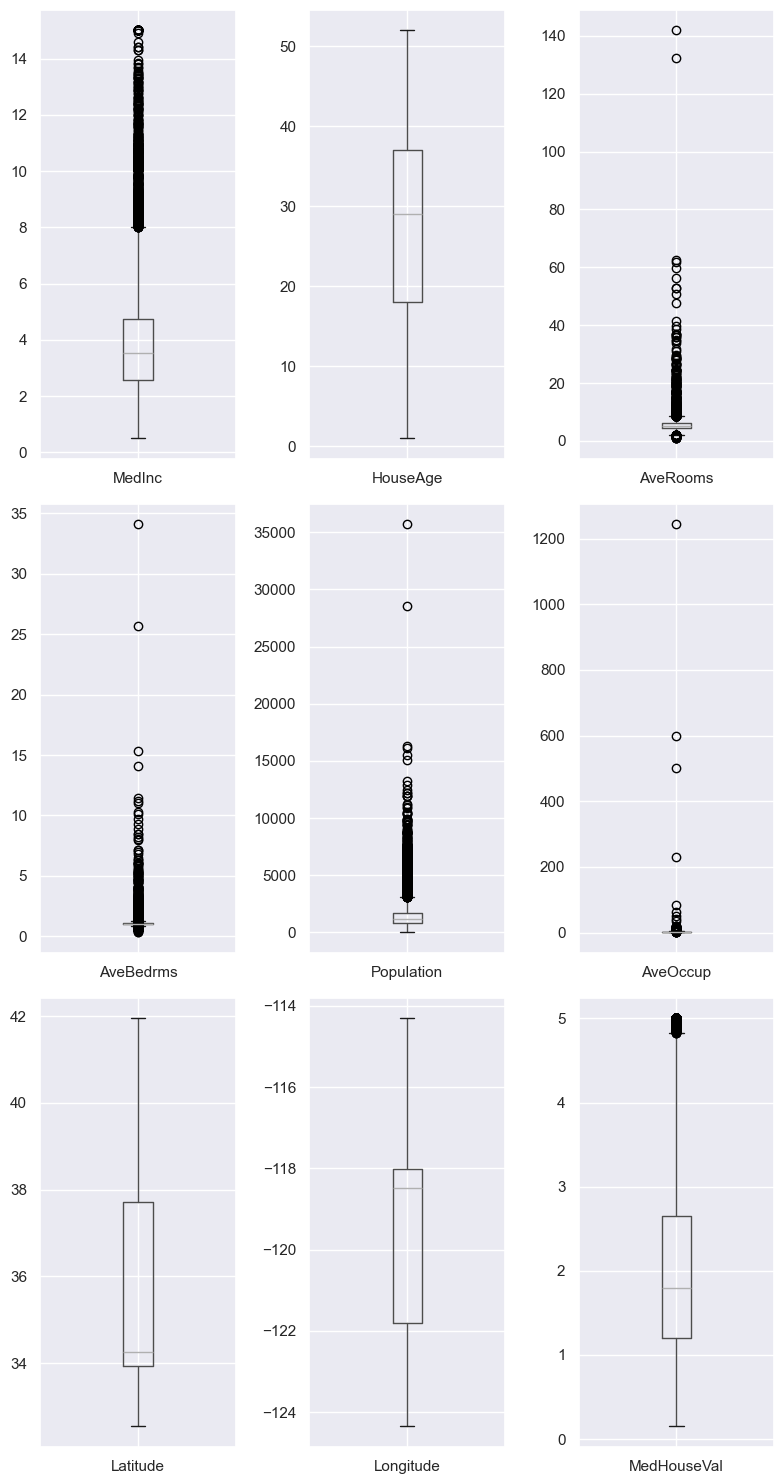

In [97]:
# Visualizamos otuliers
fig, axes = plt.subplots(3, 3, figsize= (8,15))

for i, el in enumerate(df_housing.columns.values):
    df_housing.boxplot(el, ax=axes.flatten()[i])

plt.tight_layout()
plt.show()

In [98]:
Q1 = df_housing.quantile(0.25)
Q3 = df_housing.quantile(0.75)
IQR = Q3 - Q1
mask = ((df_housing < (Q1 - 1.5 * IQR)) | (df_housing > (Q3 + 1.5 * IQR)))

print("\nOutilers primer cuartil:")
print(df_housing[df_housing < (Q1 - 1.5 * IQR)].count())
print("\nOutliers tercer cuartil:")
print(df_housing[df_housing > (Q3 + 1.5 * IQR)].count())


Outilers primer cuartil:
MedInc           0
HouseAge         0
AveRooms        45
AveBedrms      188
Population       0
AveOccup         7
Latitude         0
Longitude        0
MedHouseVal      0
dtype: int64

Outliers tercer cuartil:
MedInc          681
HouseAge          0
AveRooms        466
AveBedrms      1236
Population     1196
AveOccup        704
Latitude          0
Longitude         0
MedHouseVal    1071
dtype: int64


In [99]:
print("\nOutliers totales:")
print(df_housing[mask].count())


Outliers totales:
MedInc          681
HouseAge          0
AveRooms        511
AveBedrms      1424
Population     1196
AveOccup        711
Latitude          0
Longitude         0
MedHouseVal    1071
dtype: int64


In [100]:
df_housing_wout_outliers = df_housing.copy()
df_housing_wout_outliers[mask] = np.nan
print("\nPorcentaje de outliers:", (len(df_housing) - len(df_housing_wout_outliers.dropna()))/len(df_housing)*100)


Porcentaje de outliers: 20.968992248062015


### Ejericio 1:

> 1. 1. Obtener la correlación entre los atributos y los atributos con el target. ¿Cuál atributo tiene mayor correlación lineal con el target y cuáles atributos parecen estar más correlacionados entre sí? Se puede obtener los valores o directamente graficar usando un mapa de calor.

#### Correlación entre los atributos

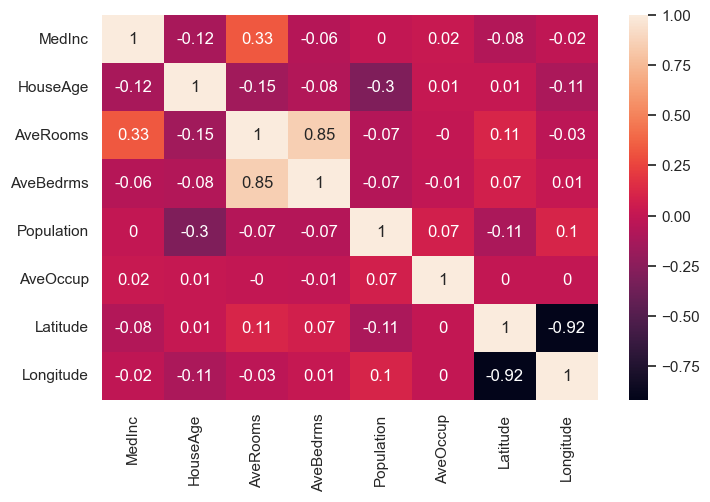

In [101]:
# Correlación entre los atributos.
plt.figure(figsize=(8, 5))
sns.heatmap(data=X.corr().round(2), annot=True)
plt.show()

*Según el mapa de calor, podemos ver que los atributos que están más relacionados son la cantidad de habitaciones junto la cantidad de cuartos de dormir (bedrooms). Esto parece lógico, en el sentido de que un conjunto pertenece a otro (cuartos de dormir es subconjunto de habitaciones). Y la latitud y longitud.*

#### Correlación entre la variable objetivo

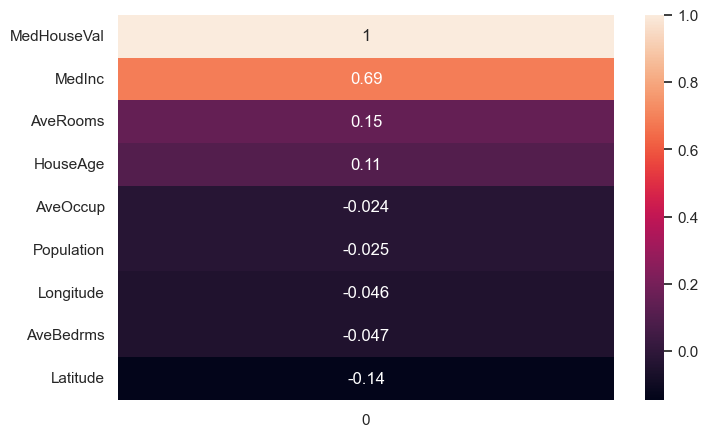

In [102]:
# Correlación con la variable objetivo.
plt.figure(figsize=(8,5))
sns.heatmap(data=pd.DataFrame(df_housing.corrwith(df_housing['MedHouseVal']).sort_values(ascending=False)), annot=True)
plt.show()

*Podemos observar que el atributo MedInc tiene una alta relación lineal con la variable objetivo.*

### Ejericio 2:

> 2. Graficar los histogramas de los diferentes atributos y el target. ¿Qué tipo de forma de histograma se observa? ¿Se observa alguna forma de campana que nos indique que los datos pueden provenir de una distribución gaussiana, sin entrar en pruebas de hipótesis?

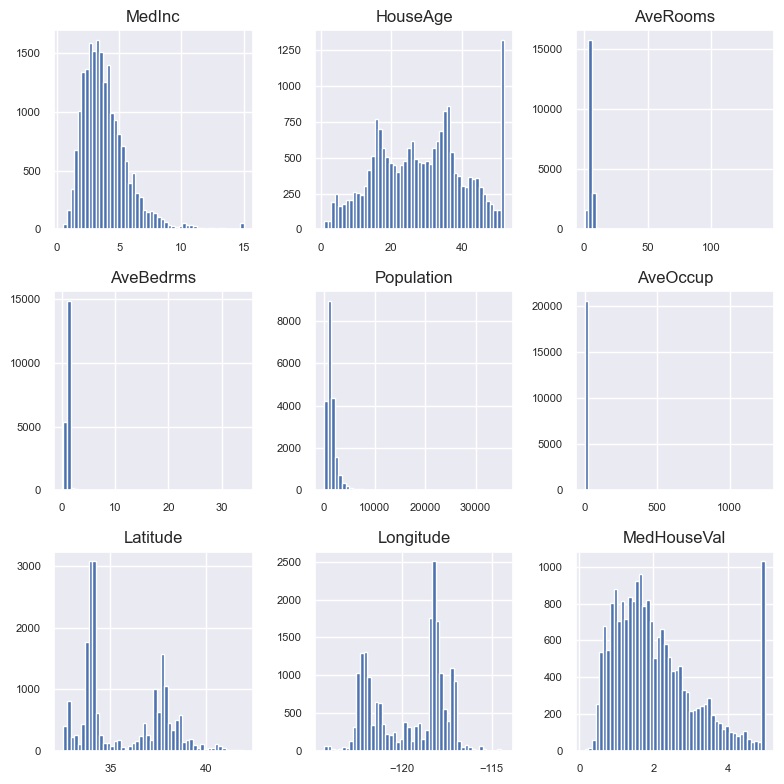

In [103]:
df_housing.hist(figsize=(8,8), xlabelsize=8, ylabelsize=8, bins=50)
plt.tight_layout()
plt.show()

*Podemos observar que hay datos que no siguen una distribución gausiana, sin embargo, hay otros que sí podrían seguir, como: MedInc e HouseAge, así como la variable objetivo.*

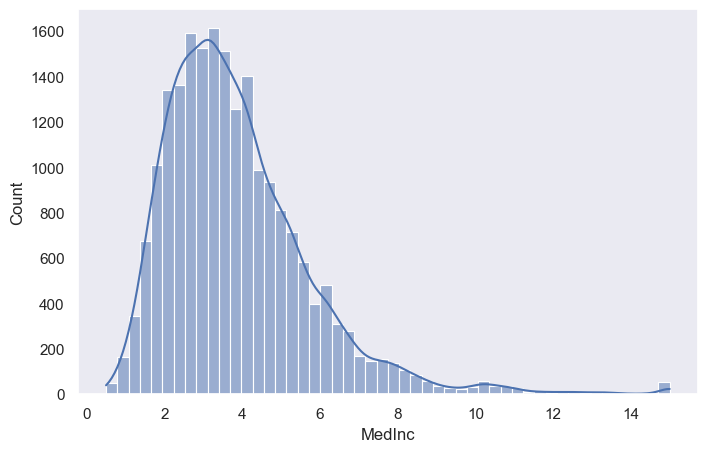

In [104]:
# Graficamos para el atributo MedInc
df_for_ploting = df_housing['MedInc']
plt.figure(figsize=(8, 5))
sns.histplot(data=df_for_ploting, kde=True, bins=50)
plt.show()

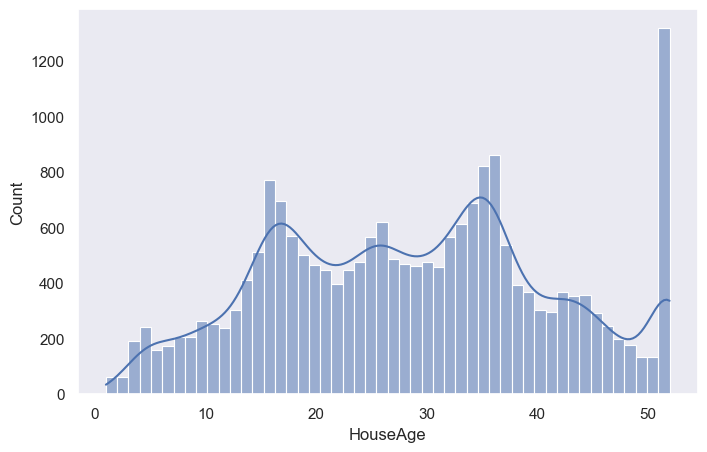

In [105]:
# Graficamos para el atributo HouseAge
df_for_ploting = df_housing['HouseAge']
plt.figure(figsize=(8, 5))
sns.histplot(data=df_for_ploting, kde=True, bins=50)
plt.show()

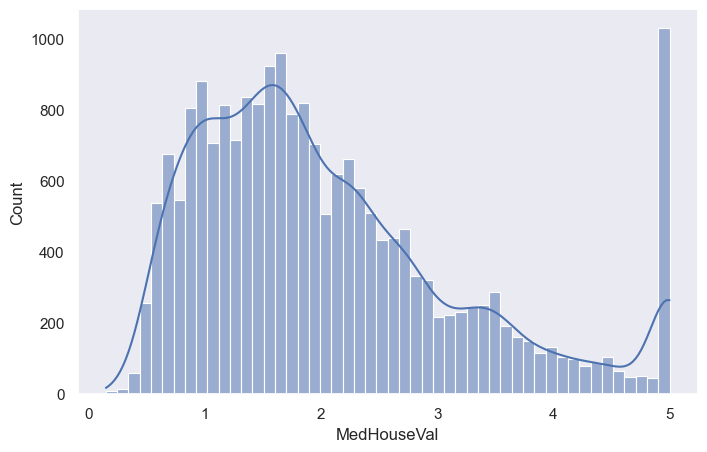

In [106]:
# Graficamos para el atributo MedHouseVal
df_for_ploting = df_housing['MedHouseVal']
plt.figure(figsize=(8, 5))
sns.histplot(data=df_for_ploting, kde=True, bins=50)
plt.show()

### Ejercicio 3:

> 3. Calcular la regresión lineal usando todos los atributos. Con el set de entrenamiento, calcular la varianza total del modelo y la que es explicada con el modelo. ¿El modelo está capturando el comportamiento del target? Expanda su respuesta.

In [107]:
# Separando nuestro dataset en entrenamiento y testeo
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Datos de train y de test
print("Dimension de X_train:",X_train.shape)
print("Valores de y_train:",y_train.size)
print("Dimension de X_test:",X_test.shape)
print("Valores de y_test:",len(y_test))

Dimension de X_train: (14448, 8)
Valores de y_train: 14448
Dimension de X_test: (6192, 8)
Valores de y_test: 6192


In [108]:
# Para normalizar un dataframe:
# normalized_df=(df-df.mean())/df.std() # Estandarizar utilizando la media.
# normalized_df=(df-df.min())/(df.max()-df.min()) # Normalizar utilizando min-max

# Escalo los datos.
sc_X = StandardScaler()
# min_max_scaler = MinMaxScaler()

# Conjunto de entrenamiento.
X_train_scaled = sc_X.fit_transform(X_train)
# Conjunto de evaluación.
X_test_scaled = sc_X.transform(X_test)
# Para quedarme con el nombre de las columnas si quiero:
# df = pd.DataFrame(X_train_scaled, colums=X.colums)

print(f"Las medias del escalador es {sc_X.mean_}")
print(f"Los desvío estándar del escalador es {np.sqrt(sc_X.var_)}")

Las medias del escalador es [ 3.87689155e+00  2.85753738e+01  5.43812463e+00  1.09803314e+00
  1.42792733e+03  3.11923650e+00  3.56506693e+01 -1.19584102e+02]
Los desvío estándar del escalador es [1.90484248e+00 1.26131971e+01 2.45348438e+00 4.47482496e-01
 1.14018573e+03 1.23732074e+01 2.13566827e+00 2.00286090e+00]


<Figure size 800x500 with 0 Axes>

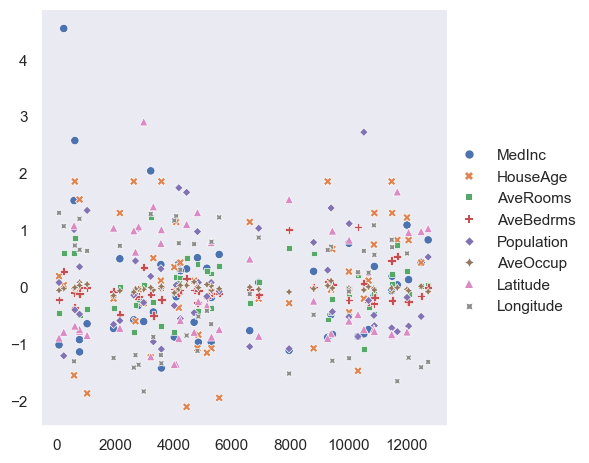

In [109]:
# Hago un preview gráfico de los datos.
plt.figure(figsize=(8, 5))
sns.relplot(pd.DataFrame(X_train_scaled, columns=X.columns.values).sample(50))
plt.show()

In [110]:
# Entrenamiento.
linear_model = LinearRegression()

linear_model.fit(X_train_scaled, y_train)

print(f"El valor de la interseccion de la recta sera {linear_model.intercept_ }")
print(f"Los valores de los coeficientes de la recta sera {linear_model.coef_ }")

El valor de la interseccion de la recta sera 2.0692396089424165
Los valores de los coeficientes de la recta sera [ 8.49221760e-01  1.22119309e-01 -2.99558449e-01  3.48409673e-01
 -8.84488134e-04 -4.16980388e-02 -8.93855649e-01 -8.68616688e-01]


In [111]:
# Coeficiente de pearson.
print(f"El coeficiente de Pearson es {linear_model.score(X_train_scaled, y_train)}")

El coeficiente de Pearson es 0.609345972797216


In [112]:
# Calculamos el desvío estándar del modelo
# S_E (Varianza que no explica el model0)
std_S_E = np.sum((y_train - linear_model.predict(X_train_scaled))**2)
print(f"Varianza que no explica el modeo {std_S_E}")

# S_T (Varianza que explica el modelo)
std_S_R = np.sum((linear_model.predict(X_train_scaled) - np.mean(y_train))**2)
print(f"Varianza que epxlica el modelo {std_S_R}")

# Desvio estandar del modelo.
std_dev_model = np.sqrt(std_S_E/(y_train.size - X.columns.size - 1))
print(f"Desvío estándar del modelo {std_dev_model}")

Varianza que no explica el modeo 7561.471021289251
Varianza que epxlica el modelo 11794.456461225065
Desvío estándar del modelo 0.7236600333345641


*Como tenemos un $R^2$ bastante alejado de 1, podemos decir que el modelo no ajusta bien los datos, ya que los residuos no son lo suficientemente chicos (cuanto más cerca de 1 esté el coficiente de Pearson, indica un mejor ajuste, o sea, residuos más chicos). Esto aasumiendo que la relación entre las variables independientes y la variable dependiente es realmente linea y el residuo se distribuye de forma normal*

### Ejercicio 4:

> 4. Calcular las métricas de MSE, MAE y $R^2$ del set de evaluación.

In [113]:
# Obtenemos las predicciones utilizando el conjunto de evaluación.
y_pred = linear_model.predict(X_test_scaled)

In [114]:
# Obtenemos los errores del modelo.
r2_lineal = r2_score(y_test, y_pred) # Cuanto más se acerque a 1 mejor.
mae_lineal = mean_absolute_error(y_test, y_pred) # Cuanto más se acerque a 0 mejor.
mse_lineal = mean_squared_error(y_test, y_pred) # Cuanto más se acerque a 0 mejor.

print("R-cuadrado en test:", r2_lineal)
print("Error absoluto medio:", mae_lineal)
print("Error cuadratico medio:", mse_lineal)

R-cuadrado en test: 0.5957702326061665
Error absoluto medio: 0.5272474538305952
Error cuadratico medio: 0.5305677824766752


### Ejercicio 5:

> 5. Crear una regresión de Ridge. Usando una validación cruzada de 5-folds y usando como métrica el MSE, calcular el mejor valor de $\alpha$, buscando entre [0, 12.5]. 
Graficar el valor de MSE versus $\alpha$.

In [115]:
# Modelo Ridge.
alpha = 10
ridge_model = Ridge(alpha=alpha)

ridge_model.fit(X_train_scaled, y_train)
print(f"El valor de la interseccion de la recta sera {ridge_model.intercept_ }")
print(f"Los valores de los coeficientes de la recta sera {ridge_model.coef_ }")

El valor de la interseccion de la recta sera 2.0692396089424165
Los valores de los coeficientes de la recta sera [ 8.48518990e-01  1.23000589e-01 -2.97069387e-01  3.45348512e-01
 -5.84614949e-04 -4.17408932e-02 -8.85416224e-01 -8.60056304e-01]


In [116]:
# Obtenemos las predicciones utilizando el conjunto de evaluación.
y_pred = ridge_model.predict(X_test_scaled)

In [117]:
# Obtenemos los errores del modelo.
r2_ridge = r2_score(y_test, y_pred) # Cuanto más se acerque a 1 mejor.
mae_ridge = mean_absolute_error(y_test, y_pred) # Cuanto más se acerque a 0 mejor.
mse_ridge = mean_squared_error(y_test, y_pred) # Cuanto más se acerque a 0 mejor.

print("R-cuadrado en test:", r2_ridge)
print("Error absoluto medio:", mae_ridge)
print("Error cuadratico medio:", mse_ridge)

R-cuadrado en test: 0.5959440604913042
Error absoluto medio: 0.5272132899793809
Error cuadratico medio: 0.5303396264055754


In [118]:
# Obtenemos una lista de alphas a probar.
alpha_values = np.linspace(0, 12.5, 100)
mse_values = []

for alpha in alpha_values:
    # Creamos el modelo con el alpha actual
    ridge_model = Ridge(alpha=alpha)

    # Ejecutamos cross validation para ese alpha.
    cv = cross_val_score(ridge_model, X_train_scaled, y=y_train, scoring="neg_mean_squared_error", cv=5, n_jobs=-1)
    # cv = cross_val_score(ridge_model, X_train_scaled, y=y_train, scoring="neg_mean_absolute_error", cv=5, n_jobs=-1)

    # Guardamos la media del MSE.
    mse_values.append(cv.mean()*-1)

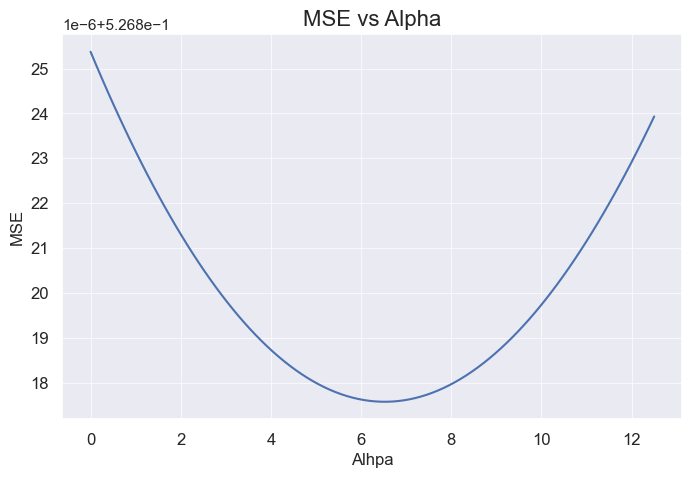

In [119]:
# Graficamos.
plt.figure(figsize=(8, 5))
plt.plot(alpha_values, mse_values)
plt.grid(True, linewidth=0.5)
plt.xlabel('Alhpa')
plt.ylabel('MSE')
plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=12)
plt.title('MSE vs Alpha', fontsize=16)
plt.show()

In [120]:
print(f"El valor de alpha que minimiza el error es alpha={alpha_values[np.argmin(np.array(mse_values))]}")

El valor de alpha que minimiza el error es alpha=6.565656565656566


### Ejercicio 6:

> 6. Comparar, entre la regresión lineal y la mejor regresión de Ridge, los resultados obtenidos en el set de evaluación. 
¿Cuál da mejores resultados (usando MSE y MAE)? Conjeturar por qué el mejor modelo mejora. ¿Qué error puede haberse reducido?

In [121]:
# Calculamos el error del modelo ridge mejorado.
ridge_model = Ridge(alpha=alpha_values[np.argmin(np.array(mse_values))])

ridge_model.fit(X_train_scaled, y_train)

# Obtenemos las predicciones utilizando el conjunto de evaluación.
y_pred = ridge_model.predict(X_test_scaled)

# Obtenemos los errores del modelo.
r2_ridge = r2_score(y_test, y_pred) # Cuanto más se acerque a 1 mejor.
mae_ridge = mean_absolute_error(y_test, y_pred) # Cuanto más se acerque a 0 mejor.
mse_ridge = mean_squared_error(y_test, y_pred) # Cuanto más se acerque a 0 mejor.

In [122]:
print("Ridge")
print("R-cuadrado en test:", r2_ridge)
print("Error absoluto medio:", mae_ridge)
print("Error cuadratico medio:", mse_ridge)

Ridge
R-cuadrado en test: 0.5958866942308552
Error absoluto medio: 0.5272217082364
Error cuadratico medio: 0.5304149219232501


In [123]:
print("Lineal")
print("R-cuadrado en test:", r2_lineal)
print("Error absoluto medio:", mae_lineal)
print("Error cuadratico medio:", mse_lineal)

Lineal
R-cuadrado en test: 0.5957702326061665
Error absoluto medio: 0.5272474538305952
Error cuadratico medio: 0.5305677824766752


*El modelo mejora muy poco. Cabe destacar la posibilidad de que un modelo lineal lo logra generalizar correctamente. En este caso se redujeron en menor medida los errores.*

*Podríamos analizar según las métricas AIC y BIC cual feature sacar...*

In [124]:
def criterion(X, y, y_pred):
    # Agregamos uno porque hay que incorporar a la ordenada al origen
    d = X.shape[1]+1
    N = X.shape[0]

    # Calculamos los residuos al cuadrado
    residuals = y - y_pred
    Se = np.sum(residuals**2)
    # Se/N es la estimación de la varianza si los residuos provienen
    # de una normal con media cero.

    # Calculamos la estimación del logaritmo de maxima similitud de la regresión lineal
    log_lik = np.log(2*np.pi) + np.log(Se/N) + 1
    log_lik *= -N/2

    #Calculamos ambos criterios
    aic = 2*d - 2*log_lik 
    bic = d*np.log(N) - 2*log_lik
   
    return aic, bic

In [125]:
# Recuperamos las columnas en X_train_scaled y X_test_scaled
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

In [126]:
regresion = LinearRegression()
regresion.fit(X_train_scaled, y_train)
y_pred = regresion.predict(X_train_scaled)

aic, bic = criterion(X_train_scaled, y_train, y_pred)

print(f"AIC inicial es {np.round(aic)}")
print(f"BIC inicial es {np.round(bic)}")

AIC inicial es 31665.0
BIC inicial es 31733.0


In [127]:
def train_reg_model(X, y, columns):

    # Quitamos las columnas
    X_clear = X.loc[:, columns].copy()
    
    model = LinearRegression()
    model.fit(X_clear, y)
    y_pred = model.predict(X_clear)

    return criterion(X_clear, y, y_pred)

In [128]:
for i, el in enumerate(X_train_scaled.columns.values):
   aic, bic = train_reg_model(X_train_scaled, y_train, np.delete(X_train_scaled.columns.values, i))

   print(f"Sacamos a {X_train_scaled.columns[i]}, el modelo nos da:")
   print(f"AIC {np.round(aic, 1)}")
   print(f"BIC {np.round(bic, 1)}")

Sacamos a MedInc, el modelo nos da:
AIC 38014.0
BIC 38074.6
Sacamos a HouseAge, el modelo nos da:
AIC 31991.8
BIC 32052.5
Sacamos a AveRooms, el modelo nos da:
AIC 31961.2
BIC 32021.9
Sacamos a AveBedrms, el modelo nos da:
AIC 32138.1
BIC 32198.8
Sacamos a Population, el modelo nos da:
AIC 31662.7
BIC 31723.4
Sacamos a AveOccup, el modelo nos da:
AIC 31710.1
BIC 31770.7
Sacamos a Latitude, el modelo nos da:
AIC 33907.5
BIC 33968.1
Sacamos a Longitude, el modelo nos da:
AIC 33864.8
BIC 33925.4


In [130]:
# Probamos sacar population.
X_train_scaled.drop('Population', inplace=True, axis=1)
X_train_scaled

,MedInc,HouseAge,AveRooms,AveBedrms,AveOccup,Latitude,Longitude
0,0.133506,0.509357,0.181060,-0.273850,-0.010825,-0.805682,0.780934
1,-0.532218,-0.679873,-0.422630,-0.047868,-0.089316,-1.339473,1.245270
2,0.170990,-0.362745,0.073128,-0.242600,-0.044800,-0.496645,-0.277552
3,-0.402916,-1.155565,0.175848,-0.008560,-0.075230,1.690024,-0.706938
4,-0.299285,1.857152,-0.259598,-0.070993,-0.066357,0.992350,-1.430902
...,...,...,...,...,...,...,...
14443,1.308827,0.509357,0.281603,-0.383849,-0.007030,-0.875918,0.810891
14444,-0.434100,0.350793,0.583037,0.383154,0.063443,-0.763541,1.075513
14445,-0.494787,0.588640,-0.591570,-0.040978,0.017201,-0.758858,0.601191
14446,0.967171,-1.076283,0.390149,-0.067164,0.004821,0.903385,-1.186252


In [131]:
for i, el in enumerate(X_train_scaled.columns.values):
   aic, bic = train_reg_model(X_train_scaled, y_train, np.delete(X_train_scaled.columns.values, i))

   print(f"Sacamos a {X_train_scaled.columns[i]}, el modelo nos da:")
   print(f"AIC {np.round(aic, 1)}")
   print(f"BIC {np.round(bic, 1)}")

Sacamos a MedInc, el modelo nos da:
AIC 38015.9
BIC 38069.0
Sacamos a HouseAge, el modelo nos da:
AIC 32028.0
BIC 32081.1
Sacamos a AveRooms, el modelo nos da:
AIC 31959.4
BIC 32012.4
Sacamos a AveBedrms, el modelo nos da:
AIC 32136.2
BIC 32189.2
Sacamos a AveOccup, el modelo nos da:
AIC 31708.7
BIC 31761.7
Sacamos a Latitude, el modelo nos da:
AIC 33926.4
BIC 33979.4
Sacamos a Longitude, el modelo nos da:
AIC 33873.8
BIC 33926.9


In [133]:
# Probamos el modelo
X_test_scaled.drop('Population', inplace=True, axis=1)
linear_model = LinearRegression()

linear_model.fit(X_train_scaled, y_train)

y_pred = linear_model.predict(X_test_scaled)

# Obtenemos los errores del modelo.
r2_lineal = r2_score(y_test, y_pred) # Cuanto más se acerque a 1 mejor.
mae_lineal = mean_absolute_error(y_test, y_pred) # Cuanto más se acerque a 0 mejor.
mse_lineal = mean_squared_error(y_test, y_pred) # Cuanto más se acerque a 0 mejor.

print("R-cuadrado en test:", r2_lineal)
print("Error absoluto medio:", mae_lineal)
print("Error cuadratico medio:", mse_lineal)

R-cuadrado en test: 0.5957536316726515
Error absoluto medio: 0.5272555831941121
Error cuadratico medio: 0.5305895718677406


*Como no hay ninguno menor que las metricas iniciales, no podemos sacar ningún otro. Igualmente el modelo no mejoró en función del esfuerzo.* 😔